In [1]:
import palaestrai as pal
from palaestrai.core import RuntimeConfig as PalRc
from palaestrai.store import Session
import palaestrai.store.database_model as paldb

In [2]:
import os
import sys
import pathlib
from datetime import datetime

In [3]:
import ipywidgets
import numpy as np
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
import sqlparse
import sqlalchemy as sa
import sqlalchemy.dialects.postgresql
from sqlalchemy.sql.expression import func

In [5]:
import ruamel.yaml
YAML = ruamel.yaml.YAML(typ="safe")

In [6]:
NOTEBOOK_DIR = pathlib.Path(os.path.abspath(os.getcwd()))

In [7]:
EXPERIMENT_RUN_YML = YAML.load(
    NOTEBOOK_DIR
    / ".."
    / "palaestrai-runfiles"
    / "Combined Voltage Band Defender Experiment_run-0.yml"
)
EXPERIMENT_RUN_YML

{'run_config': {'condition': {'name': 'palaestrai.experiment:VanillaRunGovernorTerminationCondition',
   'params': {}}},
 'schedule': [{'phase0': {'agents': [{'actuators': ['midas_powergrid.Pysimmods-0.Photovoltaic-1.p_set_mw',
       'midas_powergrid.Pysimmods-0.Photovoltaic-1.q_set_mvar',
       'midas_powergrid.Pysimmods-0.Photovoltaic-4.p_set_mw',
       'midas_powergrid.Pysimmods-0.Photovoltaic-4.q_set_mvar',
       'midas_powergrid.Pysimmods-0.Photovoltaic-5.p_set_mw',
       'midas_powergrid.Pysimmods-0.Photovoltaic-5.q_set_mvar',
       'midas_powergrid.Pysimmods-0.Battery-0.p_set_mw',
       'midas_powergrid.Powergrid-0.0-trafo-0.tap_pos',
       'midas_powergrid.Powergrid-0.0-trafo-1.tap_pos'],
      'brain': {'name': 'palaestrai.agent.dummy_brain:DummyBrain',
       'params': {}},
      'muscle': {'name': 'psi_objectives.reactive_power_muscle:ReactivePowerMuscle',
       'params': {}},
      'name': 'Gollum',
      'objective': {'name': 'psi_objectives.voltage_defender_objec

In [8]:
ENV_CONFIG = EXPERIMENT_RUN_YML["schedule"][0]["phase0"]["environments"][0]
ENV_CONFIG

{'environment': {'name': 'palaestrai_mosaik:MosaikEnvironment',
  'params': {'arl_sync_freq': 900,
   'description_func': 'describe',
   'end': 900001,
   'instance_func': 'get_world',
   'module': 'midas.tools.palaestrai:Descriptor',
   'params': {'config': 'midas-scenarios/classic-arl.yml',
    'end': 900001,
    'mosaik_params': {'addr': ['127.0.0.1', 56781]},
    'name': 'carl_cigre_ts',
    'start_date': '2020-05-01 00:00:00+0100',
    'step_size': 900,
    'store_params': {'buffer_size': 1000,
     'filename': 'retro_psi_midas.hdf5',
     'keep_old_files': True}},
   'silence_missing_input_connections_warning': True},
  'uid': 'midas_powergrid'},
 'reward': {'name': 'midas.tools.palaestrai.rewards:RetroPsiReward',
  'params': {}}}

In [9]:
EXP_RUN_NAME = EXPERIMENT_RUN_YML["uid"]
STEPS = (int(ENV_CONFIG["environment"]["params"]["end"]) - 1) // int(
    ENV_CONFIG["environment"]["params"]["arl_sync_freq"]
)
NPHASES = len(EXPERIMENT_RUN_YML["schedule"])
PHASES = []
for phase in EXPERIMENT_RUN_YML["schedule"]:
    for pname in phase:
        PHASES.append(pname)
EID = f'{datetime.today().strftime("%Y%m%d")}-{EXPERIMENT_RUN_YML["uid"].lower().replace(" ", "-")}-v1'

PLOT_PATH = os.path.abspath(os.path.join(os.getcwd(), "results", EID))
success = False
while not success:
    try:
        os.makedirs(PLOT_PATH, exist_ok=False)
        success = True
    except OSError:
        prev = int(EID[-1])
        EID = f"{EID[:-1]}{prev+1}"
        PLOT_PATH = os.path.abspath(os.path.join(os.getcwd(), "results", EID))

AGENTS = []
for acfg in EXPERIMENT_RUN_YML["schedule"][0]["phase0"]["agents"]:
    atype = "defender" if "andalf" in acfg["name"] else "attacker"
    AGENTS.append(
        {
            "name": acfg["name"],
            "brain": acfg["brain"]["name"].split(":")[-1],
            "goal": atype,
            "objective": acfg["objective"]["name"].split(":")[-1]
        }
    )

In [10]:
META_DATA = (
    f"# {EXP_RUN_NAME}\n\n"
    f"* {STEPS} simulation steps for each phase\n"
    f"* {NPHASES} Phases\n"
)
for phase in PHASES:
    META_DATA += f"  * {phase}\n"
for agent in AGENTS:
    META_DATA += (
        f"* {agent['brain']} {agent['goal']}\n"
        f"  * name={agent['name']}\n"
        f"  * objective={agent['objective']}\n"
    )

META_DATA += (
    "\n# Experiment Run Dump\n\n"
    f"{EXPERIMENT_RUN_YML}"
)
REWARD_VOLTAGE = os.path.join(PLOT_PATH, "reward_voltage.png")
REWARD_LOADING = os.path.join(PLOT_PATH, "reward_loading.png")
REWARD_ERIKA = os.path.join(PLOT_PATH, "reward_erika_reward.png")

with open(os.path.join(PLOT_PATH, "metadata.md"), "w") as f:
    f.write(META_DATA)
    f.write("\n\n*Created at ")
    f.write(datetime.now().strftime("%H:%M:%S%z, %Y-%m-%d"))
    f.write("*\n")

STORE_URI = f"sqlite:///{os.path.abspath(os.path.join(os.getcwd(), '..', 'palaestrai.db'))}"

ERI_IDX = -1

In [11]:
PalRc().reset()
PalRc().load({"store_uri": STORE_URI})

In [12]:
dbh = Session()

In [13]:
q = (
    sa.select(
        paldb.ExperimentRun, 
        paldb.ExperimentRunInstance
    )
    .join(
        paldb.ExperimentRun.experiment_run_instances
    )
    .where(
        paldb.ExperimentRun.uid == EXP_RUN_NAME
    )
    .order_by(paldb.ExperimentRunInstance.id.desc())
)
eris = dbh.execute(q).all()

In [14]:
eri_selector = ipywidgets.Dropdown(
    description="Experiment Run Instance",
    options=[
        (
            f"{row[paldb.ExperimentRunInstance].id}. {row[paldb.ExperimentRunInstance].created_at}", row[paldb.ExperimentRunInstance].id
        )
        for row in eris
    ],
    style={"description": "initial"}
)
eri_selector

Dropdown(description='Experiment Run Instance', options=(('2. 2022-10-26 08:29:35', 2), ('1. 2022-10-26 08:20:…

In [15]:
eri_id = eri_selector.value
eri_id

2

In [16]:
q = (
    sa.select(
        paldb.ExperimentRunPhase
    )
    .join(
        paldb.ExperimentRunPhase.experiment_run_instance
    )
    .where(
        paldb.ExperimentRunInstance.id == eri_id
    )
    .order_by(
        paldb.ExperimentRunPhase.id.asc()
    )
)
result = dbh.execute(q).all()
phases = {
    row[paldb.ExperimentRunPhase].uid: row[paldb.ExperimentRunPhase].id
    for row in result
}
phases

{'phase0': 2, 'phase1': 3, 'phase2': 4}

In [17]:
result

[(<palaestrai.store.database_model.ExperimentRunPhase object at 0x7f00ead359a0>,),
 (<palaestrai.store.database_model.ExperimentRunPhase object at 0x7f00ead35a00>,),
 (<palaestrai.store.database_model.ExperimentRunPhase object at 0x7f00ead35a60>,)]

In [18]:
q = sa.select(paldb.ExperimentRun).where(paldb.ExperimentRun.uid == EXP_RUN_NAME)
result = dbh.execute(q).one()
experiment_run_record = result[paldb.ExperimentRun]
experiment_run_record.id, experiment_run_record.uid

(1, 'Combined Voltage Band Defender Experiment-0')

In [19]:
experiment_run_record.experiment_run_instances

In [20]:
eri_id = experiment_run_record.experiment_run_instances[ERI_IDX].id
experiment_run_record.experiment_run_instances[ERI_IDX].experiment_run_phases

In [21]:
run_phase_ids = [phase.id for phase in experiment_run_record.experiment_run_instances[ERI_IDX].experiment_run_phases]
run_phase_ids

[2, 3, 4]

In [22]:
rewards = pd.read_sql(
    sa.select(paldb.MuscleAction, paldb.ExperimentRunPhase.uid.label("phase"), paldb.Agent.name)
    .join(paldb.MuscleAction.agent)
    .join(paldb.Agent.experiment_run_phase)
    .where(paldb.ExperimentRunPhase.experiment_run_instance_id == eri_id)
    .order_by(paldb.ExperimentRunPhase.id, paldb.MuscleAction.id),
    dbh.bind
)
rewards

id                   walltime  agent_id  \
0        1 2022-10-26 08:29:52.283140         2   
1        2 2022-10-26 08:29:52.757021         3   
2        3 2022-10-26 08:29:55.697382         2   
3        4 2022-10-26 08:29:55.849534         3   
4        5 2022-10-26 08:29:56.189713         2   
...    ...                        ...       ...   
5995  5996 2022-10-26 09:04:50.132621         7   
5996  5997 2022-10-26 09:04:50.538938         6   
5997  5998 2022-10-26 09:04:50.675927         7   
5998  5999 2022-10-26 09:04:51.081362         6   
5999  6000 2022-10-26 09:04:51.247788         7   

                                               simtimes  \
0     {'midas_powergrid': {'py/object': 'palaestrai....   
1     {'midas_powergrid': {'py/object': 'palaestrai....   
2     {'midas_powergrid': {'py/object': 'palaestrai....   
3     {'midas_powergrid': {'py/object': 'palaestrai....   
4     {'midas_powergrid': {'py/object': 'palaestrai....   
...                                                 ...   
5995  {'midas_powergrid': {'py/object': 'palaestrai....   
5996  {'midas_powergrid': {'py/object': 'palaestrai....   
5997  {'midas_powergrid': {'py/object': 'palaestrai....   
5998  {'midas_powergrid': {'py/object': 'palaestrai....   
5999  {'midas_powergrid': {'py/object': 'palaestrai....   

                                        sensor_readings  \
0     [{'py/object': 'palaestrai.agent.sensor_inform...   
1     [{'py/object': 'palaestrai.agent.sensor_inform...   
2     [{'py/object': 'palaestrai.agent.sensor_inform...   
3     [{'py/object': 'palaestrai.agent.sensor_inform...   
4     [{'py/object': 'palaestrai.agent.sensor_inform...   
...                                                 ...   
5995  [{'py/object': 'palaestrai.agent.sensor_inform...   
5996  [{'py/object': 'palaestrai.agent.sensor_inform...   
5997  [{'py/object': 'palaestrai.agent.sensor_inform...   
5998  [{'py/object': 'palaestrai.agent.sensor_inform...   
5999  [{'py/object': 'palaestrai.agent.sensor_inform...   

                                     actuator_setpoints  \
0                                                    []   
1     [{'py/object': 'palaestrai.agent.actuator_info...   
2                                                    []   
3     [{'py/object': 'palaestrai.agent.actuator_info...   
4                                                    []   
...                                                 ...   
5995  [{'py/object': 'palaestrai.agent.actuator_info...   
5996  [{'py/object': 'palaestrai.agent.actuator_info...   
5997  [{'py/object': 'palaestrai.agent.actuator_info...   
5998  [{'py/object': 'palaestrai.agent.actuator_info...   
5999  [{'py/object': 'palaestrai.agent.actuator_info...   

                                                rewards   phase  \
0     [{'py/object': 'palaestrai.agent.reward_inform...  phase0   
1     [{'py/object': 'palaestrai.agent.reward_inform...  phase0   
2     [{'py/object': 'palaestrai.agent.reward_inform...  phase0   
3     [{'py/object': 'palaestrai.agent.reward_inform...  phase0   
4     [{'py/object': 'palaestrai.agent.reward_inform...  phase0   
...                                                 ...     ...   
5995  [{'py/object': 'palaestrai.agent.reward_inform...  phase2   
5996  [{'py/object': 'palaestrai.agent.reward_inform...  phase2   
5997  [{'py/object': 'palaestrai.agent.reward_inform...  phase2   
5998  [{'py/object': 'palaestrai.agent.reward_inform...  phase2   
5999  [{'py/object': 'palaestrai.agent.reward_inform...  phase2   

                   name  
0                Gollum  
1                Sauron  
2                Gollum  
3                Sauron  
4                Gollum  
...                 ...  
5995             Sauron  
5996  Gandalf The White  
5997             Sauron  
5998  Gandalf The White  
5999             Sauron  

[6000 rows x 9 columns]

In [23]:
for rew in rewards.rewards[0]:
    print(rew["reward_id"])

vm_pu-min
vm_pu-max
vm_pu-median
vm_pu-mean
vm_pu-std
lineload-min
lineload-max
lineload-median
lineload-mean
lineload-std
ErikaReward
renewable_energy
fossil_energy
ext_grid_active_usage
ext_grid_reactive_usage


In [24]:
def unpack_reward(x, i):
    if not x:
        print("Cell is empty!")
        return 0
    try:
        val = x[i]["reward_value"]["value"]
    except KeyError as err:
        try:
            val = x[i]["reward_value"]["values"][0]
        except KeyError as err:
            print(f"Error at index {i}: {err}")
            print(x[i])
            raise err
    except TypeError as err:
        try:
            print(x[i])
            return int(x[i]["reward_value"])
        except ValueError:
            return 0
    except IndexError as err:
        print(i)
        print(x)
        print(x[i])
        print(x[i]["reward_value"])

    return float(val) if x else 0.0


cols = [
    "vm_pu_min",
    "vm_pu_max",
    "vm_pu_median",
    "vm_pu_mean",
    "vm_pu_std",
    "line_min",
    "line_max",
    "line_median",
    "line_mean",
    "line_std",
    "ErikaReward",
    "renewable_energy",
    "fossil_energy",
    "ext_grid_active_usage",
    "ext_grid_reactive_usage",
]

for idx, name in enumerate(cols):
    # print(idx, name)
    # rewards.rewards.apply(lambda x: unpack_reward(x, idx))
    rewards[name] = rewards.rewards.apply(lambda x: unpack_reward(x, idx))
    # a_actions[name] = a_actions.rewards.apply(lambda x: unpack_reward(x, idx))

rewards


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



id                   walltime  agent_id  \
0        1 2022-10-26 08:29:52.283140         2   
1        2 2022-10-26 08:29:52.757021         3   
2        3 2022-10-26 08:29:55.697382         2   
3        4 2022-10-26 08:29:55.849534         3   
4        5 2022-10-26 08:29:56.189713         2   
...    ...                        ...       ...   
5995  5996 2022-10-26 09:04:50.132621         7   
5996  5997 2022-10-26 09:04:50.538938         6   
5997  5998 2022-10-26 09:04:50.675927         7   
5998  5999 2022-10-26 09:04:51.081362         6   
5999  6000 2022-10-26 09:04:51.247788         7   

                                               simtimes  \
0     {'midas_powergrid': {'py/object': 'palaestrai....   
1     {'midas_powergrid': {'py/object': 'palaestrai....   
2     {'midas_powergrid': {'py/object': 'palaestrai....   
3     {'midas_powergrid': {'py/object': 'palaestrai....   
4     {'midas_powergrid': {'py/object': 'palaestrai....   
...                                                 ...   
5995  {'midas_powergrid': {'py/object': 'palaestrai....   
5996  {'midas_powergrid': {'py/object': 'palaestrai....   
5997  {'midas_powergrid': {'py/object': 'palaestrai....   
5998  {'midas_powergrid': {'py/object': 'palaestrai....   
5999  {'midas_powergrid': {'py/object': 'palaestrai....   

                                        sensor_readings  \
0     [{'py/object': 'palaestrai.agent.sensor_inform...   
1     [{'py/object': 'palaestrai.agent.sensor_inform...   
2     [{'py/object': 'palaestrai.agent.sensor_inform...   
3     [{'py/object': 'palaestrai.agent.sensor_inform...   
4     [{'py/object': 'palaestrai.agent.sensor_inform...   
...                                                 ...   
5995  [{'py/object': 'palaestrai.agent.sensor_inform...   
5996  [{'py/object': 'palaestrai.agent.sensor_inform...   
5997  [{'py/object': 'palaestrai.agent.sensor_inform...   
5998  [{'py/object': 'palaestrai.agent.sensor_inform...   
5999  [{'py/object': 'palaestrai.agent.sensor_inform...   

                                     actuator_setpoints  \
0                                                    []   
1     [{'py/object': 'palaestrai.agent.actuator_info...   
2                                                    []   
3     [{'py/object': 'palaestrai.agent.actuator_info...   
4                                                    []   
...                                                 ...   
5995  [{'py/object': 'palaestrai.agent.actuator_info...   
5996  [{'py/object': 'palaestrai.agent.actuator_info...   
5997  [{'py/object': 'palaestrai.agent.actuator_info...   
5998  [{'py/object': 'palaestrai.agent.actuator_info...   
5999  [{'py/object': 'palaestrai.agent.actuator_info...   

                                                rewards   phase  \
0     [{'py/object': 'palaestrai.agent.reward_inform...  phase0   
1     [{'py/object': 'palaestrai.agent.reward_inform...  phase0   
2     [{'py/object': 'palaestrai.agent.reward_inform...  phase0   
3     [{'py/object': 'palaestrai.agent.reward_inform...  phase0   
4     [{'py/object': 'palaestrai.agent.reward_inform...  phase0   
...                                                 ...     ...   
5995  [{'py/object': 'palaestrai.agent.reward_inform...  phase2   
5996  [{'py/object': 'palaestrai.agent.reward_inform...  phase2   
5997  [{'py/object': 'palaestrai.agent.reward_inform...  phase2   
5998  [{'py/object': 'palaestrai.agent.reward_inform...  phase2   
5999  [{'py/object': 'palaestrai.agent.reward_inform...  phase2   

                   name  vm_pu_min  ...  line_min   line_max  line_median  \
0                Gollum   1.009076  ...  0.037907  29.436445     7.949424   
1                Sauron   1.009076  ...  0.037907  29.436445     7.949424   
2                Gollum   1.010638  ...  0.037966  28.325882     7.861020   
3                Sauron   1.010638  ...  0.037966  28.325882     7.861020   
4                Gollum   1.019061  ...  0.038282  27.058574     7.164081   
.

In [25]:
unique_rewards = rewards.drop(
    rewards.loc[(rewards.phase.str.contains("phaseIII_att_def") | rewards.phase.str.contains("phaseIV_test_att_def")) & rewards.name.str.contains("Sauron")].index
)
unique_rewards
old_rewards = rewards
rewards = unique_rewards

In [26]:
rm = 5

rewards["vm_pu_min_mean"] = rewards["vm_pu_min"].rolling(rm).mean()
rewards["vm_pu_max_mean"] = rewards["vm_pu_max"].rolling(rm).mean()
rewards["vm_pu_mean_mean"] = rewards["vm_pu_mean"].rolling(rm).mean()
rewards["vm_pu_median_mean"] = rewards["vm_pu_median"].rolling(rm).mean()
rewards["line_min_mean"] = rewards["line_min"].rolling(rm).mean()
rewards["line_max_mean"] = rewards["line_max"].rolling(rm).mean()
rewards["line_median_mean"] = rewards["line_median"].rolling(rm).mean()
rewards["line_mean_mean"] = rewards["line_mean"].rolling(rm).mean()
rewards["ErikaReward_mean"] = rewards["ErikaReward"].rolling(rm).mean()
rewards

id                   walltime  agent_id  \
0        1 2022-10-26 08:29:52.283140         2   
1        2 2022-10-26 08:29:52.757021         3   
2        3 2022-10-26 08:29:55.697382         2   
3        4 2022-10-26 08:29:55.849534         3   
4        5 2022-10-26 08:29:56.189713         2   
...    ...                        ...       ...   
5995  5996 2022-10-26 09:04:50.132621         7   
5996  5997 2022-10-26 09:04:50.538938         6   
5997  5998 2022-10-26 09:04:50.675927         7   
5998  5999 2022-10-26 09:04:51.081362         6   
5999  6000 2022-10-26 09:04:51.247788         7   

                                               simtimes  \
0     {'midas_powergrid': {'py/object': 'palaestrai....   
1     {'midas_powergrid': {'py/object': 'palaestrai....   
2     {'midas_powergrid': {'py/object': 'palaestrai....   
3     {'midas_powergrid': {'py/object': 'palaestrai....   
4     {'midas_powergrid': {'py/object': 'palaestrai....   
...                                                 ...   
5995  {'midas_powergrid': {'py/object': 'palaestrai....   
5996  {'midas_powergrid': {'py/object': 'palaestrai....   
5997  {'midas_powergrid': {'py/object': 'palaestrai....   
5998  {'midas_powergrid': {'py/object': 'palaestrai....   
5999  {'midas_powergrid': {'py/object': 'palaestrai....   

                                        sensor_readings  \
0     [{'py/object': 'palaestrai.agent.sensor_inform...   
1     [{'py/object': 'palaestrai.agent.sensor_inform...   
2     [{'py/object': 'palaestrai.agent.sensor_inform...   
3     [{'py/object': 'palaestrai.agent.sensor_inform...   
4     [{'py/object': 'palaestrai.agent.sensor_inform...   
...                                                 ...   
5995  [{'py/object': 'palaestrai.agent.sensor_inform...   
5996  [{'py/object': 'palaestrai.agent.sensor_inform...   
5997  [{'py/object': 'palaestrai.agent.sensor_inform...   
5998  [{'py/object': 'palaestrai.agent.sensor_inform...   
5999  [{'py/object': 'palaestrai.agent.sensor_inform...   

                                     actuator_setpoints  \
0                                                    []   
1     [{'py/object': 'palaestrai.agent.actuator_info...   
2                                                    []   
3     [{'py/object': 'palaestrai.agent.actuator_info...   
4                                                    []   
...                                                 ...   
5995  [{'py/object': 'palaestrai.agent.actuator_info...   
5996  [{'py/object': 'palaestrai.agent.actuator_info...   
5997  [{'py/object': 'palaestrai.agent.actuator_info...   
5998  [{'py/object': 'palaestrai.agent.actuator_info...   
5999  [{'py/object': 'palaestrai.agent.actuator_info...   

                                                rewards   phase  \
0     [{'py/object': 'palaestrai.agent.reward_inform...  phase0   
1     [{'py/object': 'palaestrai.agent.reward_inform...  phase0   
2     [{'py/object': 'palaestrai.agent.reward_inform...  phase0   
3     [{'py/object': 'palaestrai.agent.reward_inform...  phase0   
4     [{'py/object': 'palaestrai.agent.reward_inform...  phase0   
...                                                 ...     ...   
5995  [{'py/object': 'palaestrai.agent.reward_inform...  phase2   
5996  [{'py/object': 'palaestrai.agent.reward_inform...  phase2   
5997  [{'py/object': 'palaestrai.agent.reward_inform...  phase2   
5998  [{'py/object': 'palaestrai.agent.reward_inform...  phase2   
5999  [{'py/object': 'palaestrai.agent.reward_inform...  phase2   

                   name  vm_pu_min  ...  ext_grid_reactive_usage  \
0                Gollum   1.009076  ...                 0.630811   
1                Sauron   1.009076  ...                 0.630811   
2                Gollum   1.010638  ...                 0.044016   
3                Sauron   1.010638  ...                 0.044016   
4                Gollum   1.019061  ...                -0.467121   
...                 ...        ...  ...                

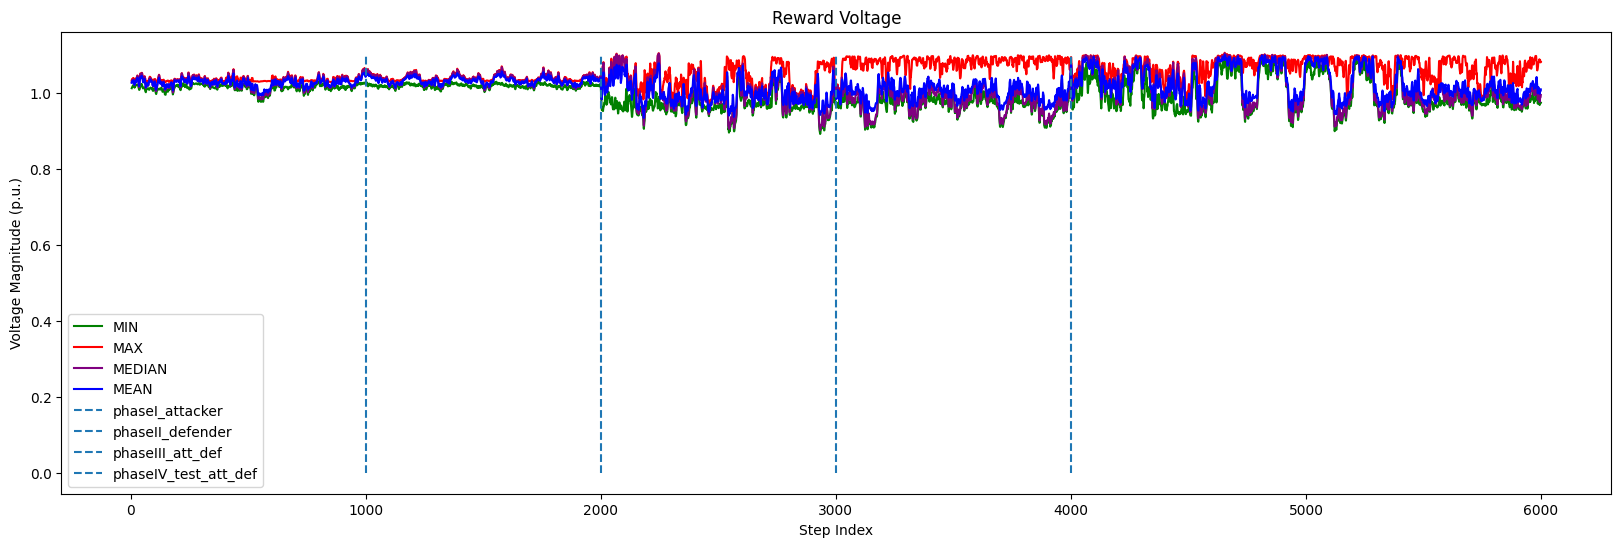

In [27]:
index = np.arange(len(rewards.index))
plt.figure(figsize=(20, 6))
plt.plot(index, rewards.vm_pu_min_mean, color="green", label="MIN")
plt.plot(index, rewards.vm_pu_max_mean, color="red", label="MAX")
plt.plot(index, rewards.vm_pu_median_mean, color="purple", label="MEDIAN")
plt.plot(index, rewards.vm_pu_mean_mean, color="blue", label="MEAN")
plt.vlines(STEPS - 0.5, ymin=0.0, ymax=1.1, label="phaseI_attacker", linestyles="dashed")
plt.vlines(STEPS*2 - 0.5, ymin=0.0, ymax=1.1, label="phaseII_defender", linestyles="dashed")
plt.vlines(STEPS*3 - 0.5, ymin=0.0, ymax=1.1, label="phaseIII_att_def", linestyles="dashed")
plt.vlines(STEPS*4 - 0.5, ymin=0.0, ymax=1.1, label="phaseIV_test_att_def", linestyles="dashed")
plt.xlabel("Step Index")
plt.ylabel("Voltage Magnitude (p.u.)")
plt.title("Reward Voltage")
plt.legend()

plt.savefig(REWARD_VOLTAGE, dpi=300, bbox_inches="tight")

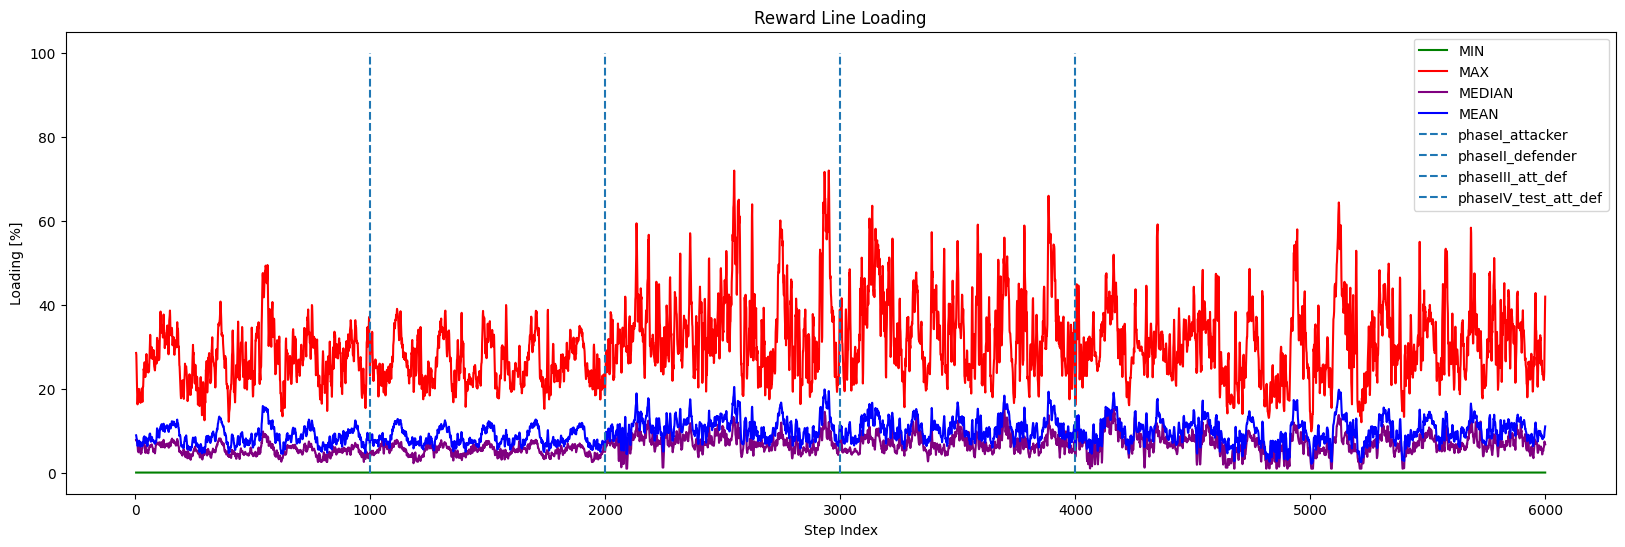

In [28]:
plt.figure(figsize=(20, 6))
plt.plot(index, rewards.line_min_mean, color="green", label="MIN")
plt.plot(index, rewards.line_max_mean, color="red", label="MAX")
plt.plot(index, rewards.line_median_mean, color="purple", label="MEDIAN")
plt.plot(index, rewards.line_mean_mean, color="blue", label="MEAN")
plt.vlines(STEPS - 0.5, ymin=0.0, ymax=100, label="phaseI_attacker", linestyles="dashed")
plt.vlines(STEPS*2 - 0.5, ymin=0.0, ymax=100, label="phaseII_defender", linestyles="dashed")
plt.vlines(STEPS*3 - 0.5, ymin=0.0, ymax=100, label="phaseIII_att_def", linestyles="dashed")
plt.vlines(STEPS*4 - 0.5, ymin=0.0, ymax=100, label="phaseIV_test_att_def", linestyles="dashed")
plt.xlabel("Step Index")
plt.ylabel("Loading [%]")
plt.title("Reward Line Loading")
plt.legend()

plt.savefig(REWARD_LOADING, dpi=300, bbox_inches="tight")

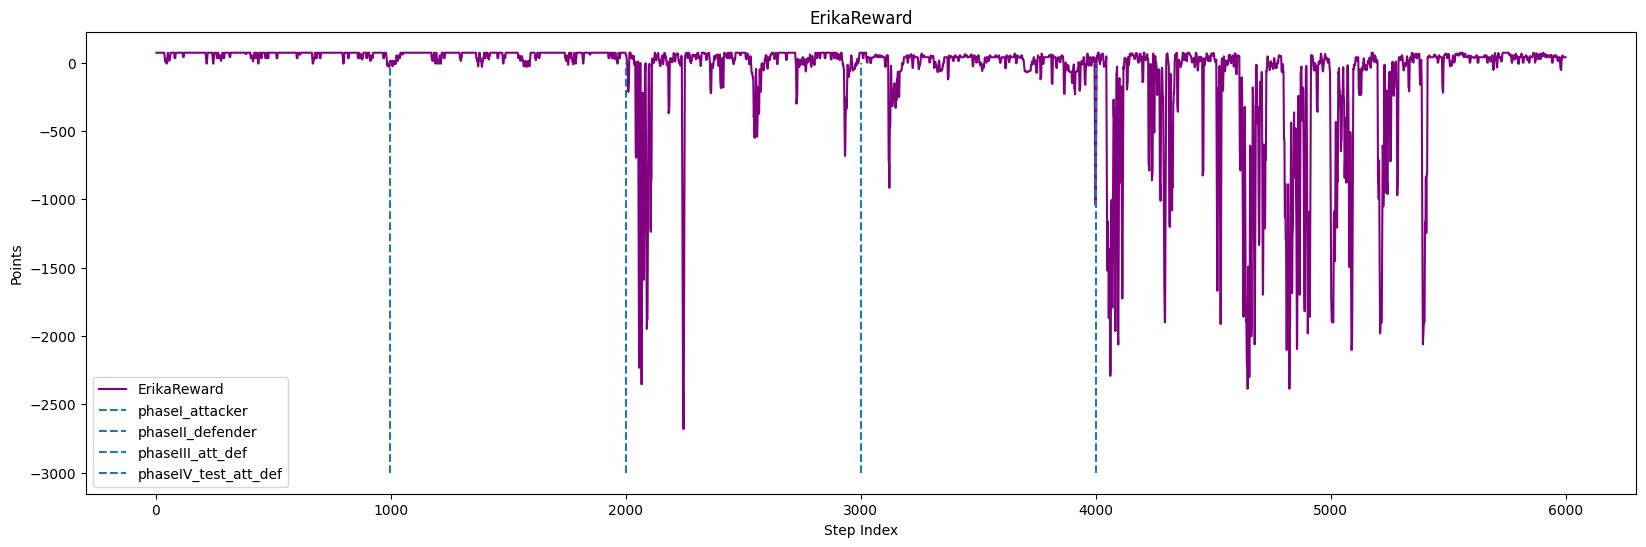

In [29]:
plt.figure(figsize=(20, 6))

plt.plot(index, rewards.ErikaReward_mean, color="purple", label="ErikaReward")
plt.vlines(STEPS - 0.5, ymin=-3000, ymax=0, label="phaseI_attacker", linestyles="dashed")
plt.vlines(STEPS*2 - 0.5, ymin=-3000, ymax=0, label="phaseII_defender", linestyles="dashed")
plt.vlines(STEPS*3 - 0.5, ymin=-3000, ymax=0, label="phaseIII_att_def", linestyles="dashed")
plt.vlines(STEPS*4 - 0.5, ymin=-3000, ymax=0, label="phaseIV_test_att_def", linestyles="dashed")
plt.xlabel("Step Index")
plt.ylabel("Points")
plt.title("ErikaReward")
plt.legend()
plt.savefig(REWARD_ERIKA, dpi=300, bbox_inches="tight")

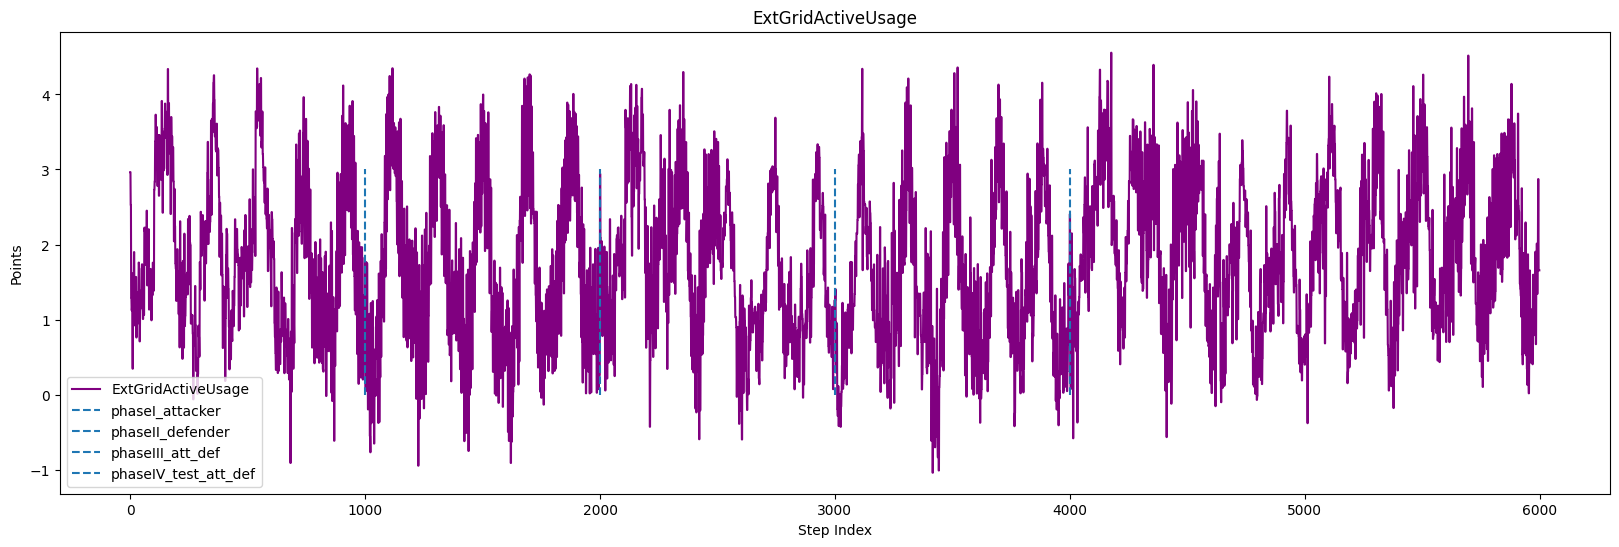

In [30]:
plt.figure(figsize=(20, 6))

plt.plot(index, rewards.ext_grid_active_usage, color="purple", label="ExtGridActiveUsage")
plt.vlines(STEPS - 0.5, ymin=-0, ymax=3, label="phaseI_attacker", linestyles="dashed")
plt.vlines(STEPS*2 - 0.5, ymin=-0, ymax=3, label="phaseII_defender", linestyles="dashed")
plt.vlines(STEPS*3 - 0.5, ymin=-0, ymax=3, label="phaseIII_att_def", linestyles="dashed")
plt.vlines(STEPS*4 - 0.5, ymin=-0, ymax=3, label="phaseIV_test_att_def", linestyles="dashed")
plt.xlabel("Step Index")
plt.ylabel("Points")
plt.title("ExtGridActiveUsage")
plt.legend()
plt.savefig(REWARD_ERIKA, dpi=300, bbox_inches="tight")

In [31]:
from psi_objectives.neighborhood_objective import NeighborhoodyObjective
from palaestrai.agent.reward_information import RewardInformation
from palaestrai.types.box import Box

In [32]:
objective = NeighborhoodyObjective()

obj_vals = [
    objective.internal_reward(
        [
            RewardInformation(
                x,
                Box(0, 100, (1,), np.double),
                reward_id="ext_grid_active_usage",
            )
        ]
    )
    for x in rewards.ext_grid_active_usage
]
obj_vals

2.9650, 0.000, -148.25081
2.9650, 0.000, -148.25081
2.5272, 0.000, -126.35881
2.5272, 0.000, -126.35881
1.2942, 0.000, -64.71191
1.2942, 0.000, -64.71191
1.1244, 0.000, -56.21808
1.1244, 0.000, -56.21808
1.1841, 0.000, -59.20608
1.1841, 0.000, -59.20608
0.3472, 0.000, -17.35985
0.3472, 0.000, -17.35985
1.6199, 0.000, -80.99562
1.6199, 0.000, -80.99562
1.4294, 0.000, -71.47219
1.4294, 0.000, -71.47219
1.8999, 0.000, -94.99630
1.8999, 0.000, -94.99630
0.9249, 0.000, -46.24443
0.9249, 0.000, -46.24443
1.0252, 0.000, -51.26084
1.0252, 0.000, -51.26084
1.1282, 0.000, -56.41206
1.1282, 0.000, -56.41206
1.5688, 0.000, -78.44141
1.5688, 0.000, -78.44141
0.7628, 0.000, -38.14012
0.7628, 0.000, -38.14012
1.3591, 0.000, -67.95710
1.3591, 0.000, -67.95710
0.9445, 0.000, -47.22734
0.9445, 0.000, -47.22734
1.3629, 0.000, -68.14459
1.3629, 0.000, -68.14459
1.2538, 0.000, -62.69073
1.2538, 0.000, -62.69073
1.7603, 0.000, -88.01612
1.7603, 0.000, -88.01612
1.6756, 0.000, -83.77920
1.6756, 0.000, -83.77

3.0522, 0.000, -152.60917
3.0110, 0.000, -150.55192
3.0110, 0.000, -150.55192
3.6185, 0.000, -180.92569
3.6185, 0.000, -180.92569
3.4481, 0.000, -172.40737
3.4481, 0.000, -172.40737
2.9507, 0.000, -147.53600
2.9507, 0.000, -147.53600
3.5605, 0.000, -178.02518
3.5605, 0.000, -178.02518
2.9122, 0.000, -145.61038
2.9122, 0.000, -145.61038
3.2246, 0.000, -161.22864
3.2246, 0.000, -161.22864
2.5792, 0.000, -128.95871
2.5792, 0.000, -128.95871
2.0030, 0.000, -100.15068
2.0030, 0.000, -100.15068
3.5070, 0.000, -175.35172
3.5070, 0.000, -175.35172
2.1829, 0.000, -109.14566
2.1829, 0.000, -109.14566
1.8824, 0.000, -94.11919
1.8824, 0.000, -94.11919
3.6271, 0.000, -181.35414
3.6271, 0.000, -181.35414
1.5790, 0.000, -78.94972
1.5790, 0.000, -78.94972
2.0952, 0.000, -104.76207
2.0952, 0.000, -104.76207
3.6753, 0.000, -183.76715
3.6753, 0.000, -183.76715
1.7037, 0.000, -85.18526
1.7037, 0.000, -85.18526
1.8158, 0.000, -90.78863
1.8158, 0.000, -90.78863
2.8449, 0.000, -142.24471
2.8449, 0.000, -142.

1.3339, 0.000, -66.69655
2.3575, 0.000, -117.87563
2.3575, 0.000, -117.87563
1.5384, 0.000, -76.91785
1.5384, 0.000, -76.91785
1.3120, 0.000, -65.59921
1.3120, 0.000, -65.59921
0.8851, 0.000, -44.25472
0.8851, 0.000, -44.25472
1.7371, 0.000, -86.85262
1.7371, 0.000, -86.85262
2.0132, 0.000, -100.65977
2.0132, 0.000, -100.65977
2.6028, 0.000, -130.14083
2.6028, 0.000, -130.14083
1.8017, 0.000, -90.08537
1.8017, 0.000, -90.08537
2.5391, 0.000, -126.95318
2.5391, 0.000, -126.95318
3.4580, 0.000, -172.90214
3.4580, 0.000, -172.90214
2.8644, 0.000, -143.22120
2.8644, 0.000, -143.22120
2.5456, 0.000, -127.27979
2.5456, 0.000, -127.27979
1.9535, 0.000, -97.67259
1.9535, 0.000, -97.67259
3.0031, 0.000, -150.15700
3.0031, 0.000, -150.15700
2.6191, 0.000, -130.95555
2.6191, 0.000, -130.95555
2.1195, 0.000, -105.97611
2.1195, 0.000, -105.97611
1.2366, 0.000, -61.82819
1.2366, 0.000, -61.82819
3.1437, 0.000, -157.18311
3.1437, 0.000, -157.18311
1.5960, 0.000, -79.79925
1.5960, 0.000, -79.79925
1.3

1.1852, 0.000, -59.25980
1.0543, 0.000, -52.71351
1.0543, 0.000, -52.71351
1.1201, 0.000, -56.00510
1.1201, 0.000, -56.00510
1.3468, 0.000, -67.34023
1.3468, 0.000, -67.34023
1.0558, 0.000, -52.79129
1.0558, 0.000, -52.79129
0.7893, 0.000, -39.46309
0.7893, 0.000, -39.46309
0.7013, 0.000, -35.06716
0.7013, 0.000, -35.06716
0.0713, 0.000, 77.07494
0.0713, 0.000, 77.07494
0.2775, 0.000, -13.87391
0.2775, 0.000, -13.87391
0.7062, 0.000, -35.31116
0.7062, 0.000, -35.31116
1.1236, 0.000, -56.17872
1.1236, 0.000, -56.17872
1.3611, 0.000, -68.05403
1.3611, 0.000, -68.05403
0.7845, 0.000, -39.22254
0.7845, 0.000, -39.22254
0.7031, 0.000, -35.15621
0.7031, 0.000, -35.15621
0.9723, 0.000, -48.61342
0.9723, 0.000, -48.61342
2.2194, 0.000, -110.97069
2.2194, 0.000, -110.97069
1.2676, 0.000, -63.37787
1.2676, 0.000, -63.37787
0.3659, 0.000, -18.29686
0.3659, 0.000, -18.29686
0.2856, 0.000, -14.27750
0.2856, 0.000, -14.27750
1.8778, 0.000, -93.88843
1.8778, 0.000, -93.88843
0.3838, 0.000, -19.18989


2.2640, 0.000, -113.19918
3.0263, 0.000, -151.31531
3.0263, 0.000, -151.31531
2.0389, 0.000, -101.94496
2.0389, 0.000, -101.94496
3.2620, 0.000, -163.10023
3.2620, 0.000, -163.10023
2.5969, 0.000, -129.84627
2.5969, 0.000, -129.84627
3.4157, 0.000, -170.78461
3.4157, 0.000, -170.78461
1.6461, 0.000, -82.30707
1.6461, 0.000, -82.30707
3.4303, 0.000, -171.51391
3.4303, 0.000, -171.51391
2.2661, 0.000, -113.30339
2.2661, 0.000, -113.30339
2.4903, 0.000, -124.51615
2.4903, 0.000, -124.51615
3.8954, 0.000, -194.77127
3.8954, 0.000, -194.77127
2.3461, 0.000, -117.30368
2.3461, 0.000, -117.30368
3.4921, 0.000, -174.60616
3.4921, 0.000, -174.60616
1.7041, 0.000, -85.20742
1.7041, 0.000, -85.20742
3.2949, 0.000, -164.74672
3.2949, 0.000, -164.74672
1.9643, 0.000, -98.21594
1.9643, 0.000, -98.21594
0.8948, 0.000, -44.73853
0.8948, 0.000, -44.73853
2.4892, 0.000, -124.45816
2.4892, 0.000, -124.45816
1.7736, 0.000, -88.68119
1.7736, 0.000, -88.68119
3.7782, 0.000, -188.90984
3.7782, 0.000, -188.90

2.3710, 0.000, -118.54799
2.3710, 0.000, -118.54799
1.0554, 0.000, -52.76902
1.0554, 0.000, -52.76902
2.5126, 0.000, -125.62770
2.5126, 0.000, -125.62770
1.9462, 0.000, -97.30988
1.9462, 0.000, -97.30988
0.7010, 0.000, -35.05089
0.7010, 0.000, -35.05089
1.3009, 0.000, -65.04558
1.3009, 0.000, -65.04558
2.9668, 0.000, -148.34052
2.9668, 0.000, -148.34052
1.4433, 0.000, -72.16482
1.4433, 0.000, -72.16482
3.5576, 0.000, -177.88018
3.5576, 0.000, -177.88018
0.9737, 0.000, -48.68729
0.9737, 0.000, -48.68729
1.5039, 0.000, -75.19331
1.5039, 0.000, -75.19331
2.7676, 0.000, -138.38243
2.7676, 0.000, -138.38243
0.7979, 0.000, -39.89523
0.7979, 0.000, -39.89523
2.3324, 0.000, -116.61756
2.3324, 0.000, -116.61756
2.0843, 0.000, -104.21675
2.0843, 0.000, -104.21675
2.2631, 0.000, -113.15430
2.2631, 0.000, -113.15430
2.5356, 0.000, -126.77843
2.5356, 0.000, -126.77843
2.6190, 0.000, -130.94756
2.6190, 0.000, -130.94756
1.7667, 0.000, -88.33463
1.7667, 0.000, -88.33463
1.7581, 0.000, -87.90469
1.758

[-148.2508134236364,
 -148.2508134236364,
 -126.35880670152252,
 -126.35880670152252,
 -64.71191298953833,
 -64.71191298953833,
 -56.21807822861895,
 -56.21807822861895,
 -59.206076899854864,
 -59.206076899854864,
 -17.3598521683574,
 -17.3598521683574,
 -80.99561544927496,
 -80.99561544927496,
 -71.47218786511723,
 -71.47218786511723,
 -94.99629913041522,
 -94.99629913041522,
 -46.24443302810651,
 -46.24443302810651,
 -51.26083613655462,
 -51.26083613655462,
 -56.41205651076488,
 -56.41205651076488,
 -78.4414068422533,
 -78.4414068422533,
 -38.14012077655089,
 -38.14012077655089,
 -67.9570989038341,
 -67.9570989038341,
 -47.22734480428944,
 -47.22734480428944,
 -68.1445895390134,
 -68.1445895390134,
 -62.690729878975496,
 -62.690729878975496,
 -88.01611593367278,
 -88.01611593367278,
 -83.77920496660283,
 -83.77920496660283,
 -35.54893644316211,
 -35.54893644316211,
 -56.71832596372458,
 -56.71832596372458,
 -65.08622288713322,
 -65.08622288713322,
 -57.75988613556946,
 -57.7598861355

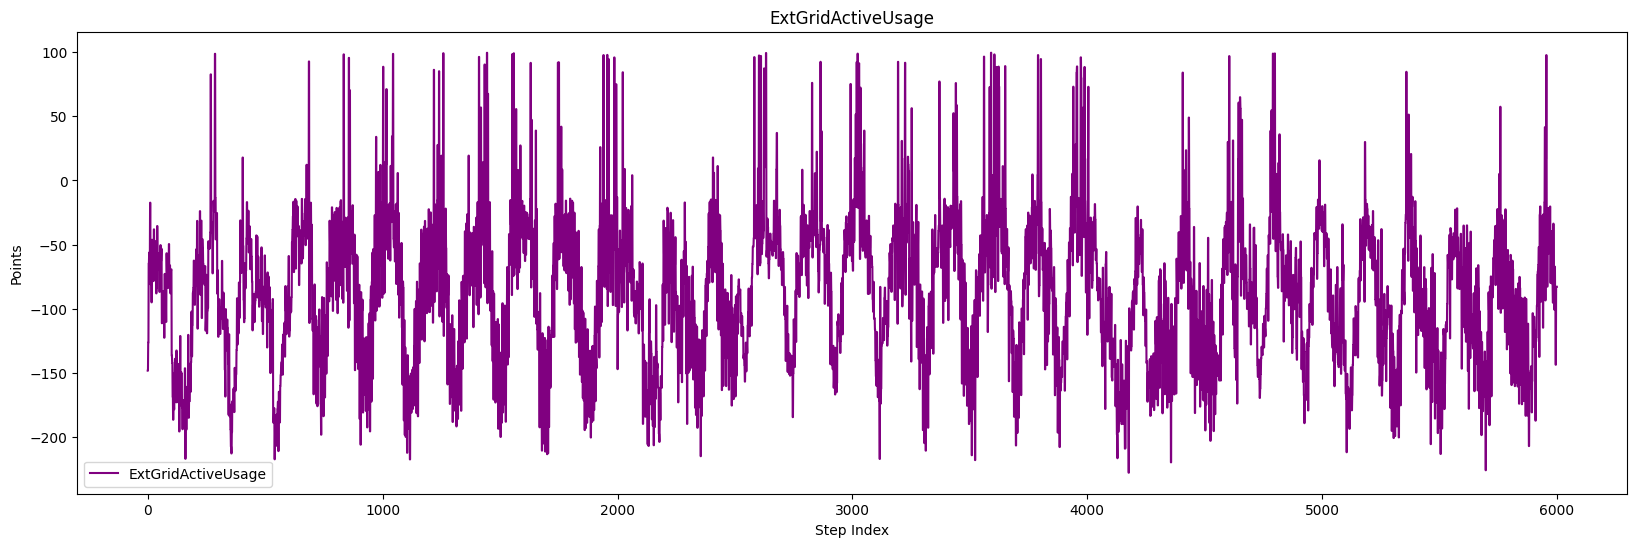

In [33]:
plt.figure(figsize=(20, 6))

plt.plot(obj_vals, color="purple", label="ExtGridActiveUsage")
# plt.vlines(STEPS - 0.5, ymin=-0, ymax=100, label="phaseI_attacker", linestyles="dashed")
# plt.vlines(STEPS*2 - 0.5, ymin=-0, ymax=100, label="phaseII_defender", linestyles="dashed")
# plt.vlines(STEPS*3 - 0.5, ymin=-0, ymax=100, label="phaseIII_att_def", linestyles="dashed")
# plt.vlines(STEPS*4 - 0.5, ymin=-0, ymax=100, label="phaseIV_test_att_def", linestyles="dashed")
plt.xlabel("Step Index")
plt.ylabel("Points")
plt.title("ExtGridActiveUsage")
plt.legend()
plt.savefig(REWARD_ERIKA, dpi=300, bbox_inches="tight")